### Import Required Packages

In [10]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Style 
import plotly.express as px
import os



### Data Integration

In [11]:
def load_data(file_path: str) -> pd.DataFrame:
    '''
    Load a Parquet file into a Pandas DataFrame, optimizing column data types.
    
    Parameters:
    file_path (str): The file path to the Parquet file.

    Returns:
    pd.DataFrame: A Pandas DataFrame containing the loaded data.
    '''
    print("=" * 21 + "Data Integration Running . . ." + "=" * 21)
    
    # Read the Parquet file into a PyArrow Table
    table = pq.read_table(file_path)
    
    # Remove metadata and cast to fixed schema
    fixed_schema = table.schema.remove_metadata()
    fixed_table = table.cast(fixed_schema)
    
    # Convert to a Pandas DataFrame
    df = fixed_table.to_pandas()
    
    # Optimize data types for memory efficiency
    # Convert float64 columns to float32
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = df[col].astype('float32')
    
    # Convert int64 columns to int32
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = df[col].astype('int32')
    
    return df


def save_csv(df: pd.DataFrame, output_path: str):
    '''
    Save the given DataFrame to a CSV file.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to save.
    output_path (str): The file path where the CSV will be saved.
    '''
    df.to_csv(output_path, index=False)  # Avoid saving index as a separate column


In [12]:
df = load_data('data/case_study_dataset.parquet')
print(df.head(n=5))
print('='*100)
print(df.shape)
print('='*100)
print(df.info())
print('='*100)
print(df.describe())
print('='*100)

=====================Data Integration Running . . .=====================
                                            searchId checkInDate checkOutDate  \
0  b'\x88\x08\x0f\xbc\xfd\xc5\x11\x9c\xb8g4\xba\x...  2024-04-08   2024-04-08   
1  b'\x88\x08\x0f\xbc\xfd\xc5\x11\x9c\xb8g4\xba\x...  2024-04-08   2024-04-08   
2  b'\x88\x08\x0f\xbc\xfd\xc5\x11\x9c\xb8g4\xba\x...  2024-04-08   2024-04-08   
3  b'\x88\x08\x0f\xbc\xfd\xc5\x11\x9c\xb8g4\xba\x...  2024-04-08   2024-04-08   
4  b'\x88\x08\x0f\xbc\xfd\xc5\x11\x9c\xb8g4\xba\x...  2024-04-08   2024-04-08   

   searchDate                destinationName  numRooms  \
0  2024-04-07  SAN ANGELO, TX, UNITED STATES       1.0   
1  2024-04-07  SAN ANGELO, TX, UNITED STATES       1.0   
2  2024-04-07  SAN ANGELO, TX, UNITED STATES       1.0   
3  2024-04-07  SAN ANGELO, TX, UNITED STATES       1.0   
4  2024-04-07  SAN ANGELO, TX, UNITED STATES       1.0   

                                              userId vipTier deviceCode  \
0  b'\x81\xeb\xc

### Data Exploration and Understanding

In [13]:
def print_separator(header):
    '''
    Print a colored separator to differentiate outputs in the console.
    
    Parameters:
        header (str): The title or description to display in the separator.
    
    Notes:
        - Uses colorama to add cyan lines and green header text for visual appeal.
    '''
    print(Fore.CYAN + Style.BRIGHT + '=' * 50)
    print(Fore.GREEN + Style.BRIGHT + f'{header}')
    print(Fore.CYAN + Style.BRIGHT + '=' * 50)
    print(Style.RESET_ALL)


def inspect_dataset(df):
    '''
    Print basic info and missing values of the DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to inspect.
    
    Outputs:
        - Shape of the dataset.
        - Data types of columns.
        - Count of missing values per column.
        - Number of duplicate rows.
    '''
    print_separator('Inspecting Dataset')
    print('Raw data. Shape:', df.shape)
    print(df.dtypes)
    print('\nMissing Values:')
    print(df.isnull().sum())
    duplicates = df[df.duplicated()]
    print('Duplicates:', duplicates)


def inspect_seasonality(df):
    '''
    Examine the presence of data across different seasons based on checkInDate.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
    
    Outputs:
        - Indicates whether data is present for Winter, Spring, Summer, and Fall.
    
    '''
    print_separator('Inspecting Seasonality')
    spring_months = [3, 4, 5]
    summer_months = [6, 7, 8]
    fall_months = [9, 10, 11]
    winter_months = [12, 1, 2]

    df['checkInDate'] = pd.to_datetime(df['checkInDate'], errors='coerce')
    unique_months = df['checkInDate'].dt.month.unique()

    season_coverage = {
        'Winter': any(month in unique_months for month in winter_months),
        'Spring': any(month in unique_months for month in spring_months),
        'Summer': any(month in unique_months for month in summer_months),
        'Fall': any(month in unique_months for month in fall_months),
    }

    for season, present in season_coverage.items():
        status = 'Present' if present else 'Missing'
        print(f'{season}: {status}')

def summarize_numerical(df, numerical_cols):
    '''
    Summarize min/max and basic statistics for numerical columns.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        numerical_cols (list): List of column names to summarize.
    
    '''
    print_separator('Summarizing Numerical Data')
    print('\nNumeric Columns - Min and Max Ranges:')
    for col in numerical_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            print(f'{col}: Min = {df[col].min()}, Max = {df[col].max()}')
    print('\nBasic Statistics (Numerical Columns):')
    print(df[numerical_cols].describe())


def preview_date_columns(df, date_cols):
    '''
    Show raw values of date columns (top 5).
    
    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        date_cols (list): List of date column names to preview.
    
    Outputs:
        - Top 5 raw values for each specified date column.
    '''
    print_separator('Previewing Date Columns')
    print('\nDate Columns (Sample of Raw Values):')
    for col in date_cols:
        print(f'{col} (Top 5): {df[col].head().tolist()}')


def explore_categorical(df, categorical_cols):
    '''
    Count unique values in categorical columns.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        categorical_cols (list): List of categorical column names to explore.
    
    Outputs:
        - Value counts and unique count for each categorical column.
    '''
    print_separator('Exploring Categorical Columns')
    print('\nUnique Values in Categorical Columns:')
    for col in categorical_cols:
        print(f'{col}:')
        print(df[col].value_counts())
        print(f'Unique count: {df[col].nunique()}')


def count_unique_ids(df, id_cols):
    '''
    Count unique values in ID columns.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        id_cols (list): List of ID column names to count.
    
    Outputs:
        - Unique count for each ID column.
    '''
    print_separator('Counting Unique IDs')
    print('\nUnique Counts in ID Columns:')
    for col in id_cols:
        print(f'{col}: {df[col].nunique()} unique values')


def explore_numerical_details(df, detailed_cols):
    '''
    Explore detailed value counts for specific numerical columns.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        detailed_cols (list): List of numerical column names for detailed exploration.
    
    Outputs:
        - Value counts and unique count for each specified column.
    '''
    print_separator('Exploring Numerical Details')
    print('\nDetailed Value Counts for Selected Numerical Columns:')
    for col in detailed_cols:
        print(f'{col}:')
        print(df[col].value_counts())
        print(f'Unique count: {df[col].nunique()}')


def plot_numerical_distributions(df, numerical_cols):
    '''
    Plot distributions of numerical columns.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        numerical_cols (list): List of numerical column names to plot.
    
    Outputs:
        - Histogram with KDE for each numerical column in a 3x3 subplot grid.
    
    '''
    print_separator('Plotting Numerical Distributions')
    plt.figure(figsize=(14, 8))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(3, 3, i)
        if pd.api.types.is_numeric_dtype(df[col]):
            sns.histplot(df[col], kde=True, bins=30)
            plt.title(f'Distribution of {col}')
        else:
            plt.text(0.5, 0.5, f'{col} is not numeric', ha='center', va='center')
            plt.title(f'{col} (Non-Numeric)')
    plt.tight_layout()
    plt.show


def analyze_targets(df, target_cols):
    '''
    Analyze distribution of target variables with proportions.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        target_cols (list): List of target column names to analyze.
    
    Outputs:
        - Normalized value counts (proportions) for each target column.
        - Visualize the target variable distribution.
    '''
    print_separator('Analyzing Target Variables')
    print('\nTarget Variable Distributions:')
    
    for col in target_cols:
        # Print the normalized value counts
        print(f'{col}:')
        print(df[col].value_counts(normalize=True))
        
        # Plotting the distribution using seaborn
        plt.figure(figsize=(8, 6))
        sns.countplot(x=col, data=df, palette='viridis')
        plt.title(f'Distribution of {col}')
        plt.ylabel('Count')
        plt.xlabel(f'{col} (0 = False, 1 = True)')
        plt.show()
        

def check_click_to_book(df):
    '''
    Check relationship between clickLabel and bookingLabel.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
    
    Outputs:
        - Cross-tabulation of clickLabel and bookingLabel with normalized rows.
    '''
    print_separator('Checking Click-to-Book Relationship')
    print('\nClick-to-Book Relationship:')
    print(pd.crosstab(df['clickLabel'], df['bookingLabel'], normalize='index'))


def plot_correlation_matrix(df, numerical_cols):
    '''
    Plot correlation matrix for numerical columns.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        numerical_cols (list): List of numerical column names for correlation.
    
    Outputs:
        - Heatmap showing correlation coefficients between numerical features.
    
    '''
    print_separator('Plotting Correlation Matrix')
    plt.figure(figsize=(10, 6))
    numeric_df = df[numerical_cols].select_dtypes(include=[np.number])
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Numerical Features')
    plt.show()


def analyze_feature_target(df, feature_cols, target_col='bookingLabel'):
    '''
    Analyze relationships between features and a target variable.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        feature_cols (list): List of feature column names to evaluate.
        target_col (str, optional): The target column name (defaults to 'bookingLabel').
    
    Outputs:
        - For numeric features: Correlation coefficient with the target.
        - For categorical features: Cross-tabulation with normalized rows.
    
    '''
    print_separator('Feature-Target Relationships')
    for col in feature_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            corr = df[col].corr(df[target_col].astype(int))  # Assuming bookingLabel is 0/1
            print(f'{col} vs {target_col} correlation: {corr:.3f}')
        else:
            crosstab = pd.crosstab(df[col], df[target_col], normalize='index')
            print(f'\n{col} vs {target_col}:\n{crosstab}')


def analyze_rank_effect(df):
    '''
    Analyze the effect of rank on booking probability.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
    
    Outputs:
        - Cross-tabulation of booking rate by rank buckets.
        - Line plot showing booking probability vs rank.
    
    '''
    print_separator('Rank Effect Analysis')
    df['rank_bucket'] = pd.qcut(df['rank'], q=5, duplicates='drop')
    print('Booking Rate by Rank Bucket:')
    print(pd.crosstab(df['rank_bucket'], df['bookingLabel'], normalize='index'))
    sns.lineplot(x='rank', y='bookingLabel', data=df, estimator='mean')
    plt.title('Booking Probability vs Rank')
    plt.show()
    # Potential Bias: The data could reflect a self-fulfilling prophecy —
    # top-ranked hotels get more clicks/bookings because they’re ranked highly,
    # not necessarily because they’re inherently better.

def run_data_exploration(df, 
                         numerical_cols, 
                         date_cols, 
                         categorical_cols, 
                         id_cols, 
                         detailed_numerical_cols, 
                         target_cols
    ):
    """Run all exploration steps."""
    inspect_dataset(df)
    inspect_seasonality(df)
    summarize_numerical(df, numerical_cols)
    preview_date_columns(df, date_cols)
    explore_categorical(df, categorical_cols)
    count_unique_ids(df, id_cols)
    explore_numerical_details(df, detailed_numerical_cols)
    plot_numerical_distributions(df, numerical_cols)
    analyze_targets(df, target_cols)
    check_click_to_book(df)
    analyze_rank_effect(df)
    plot_correlation_matrix(df, numerical_cols)


Inspecting Dataset

Raw data. Shape: (769109, 22)
searchId                object
checkInDate             object
checkOutDate            object
searchDate              object
destinationName         object
numRooms               float32
userId                  object
vipTier                 object
deviceCode              object
signedInFlag              bool
rank                   float32
hotelId                 object
brandId                 object
starLevel              float32
customerReviewScore    float32
reviewCount            float32
minPrice               float32
minStrikePrice         float32
freeBreakfastFlag         bool
freeInternetFlag          bool
bookingLabel              bool
clickLabel                bool
dtype: object

Missing Values:
searchId                   0
checkInDate                0
checkOutDate               0
searchDate                 0
destinationName        18730
numRooms                   0
userId                     0
vipTier                    0
devic

/var/folders/fd/qk43m_591sbfv7hhlz7_dnmm0000gn/T/ipykernel_17809/828760509.py:208: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


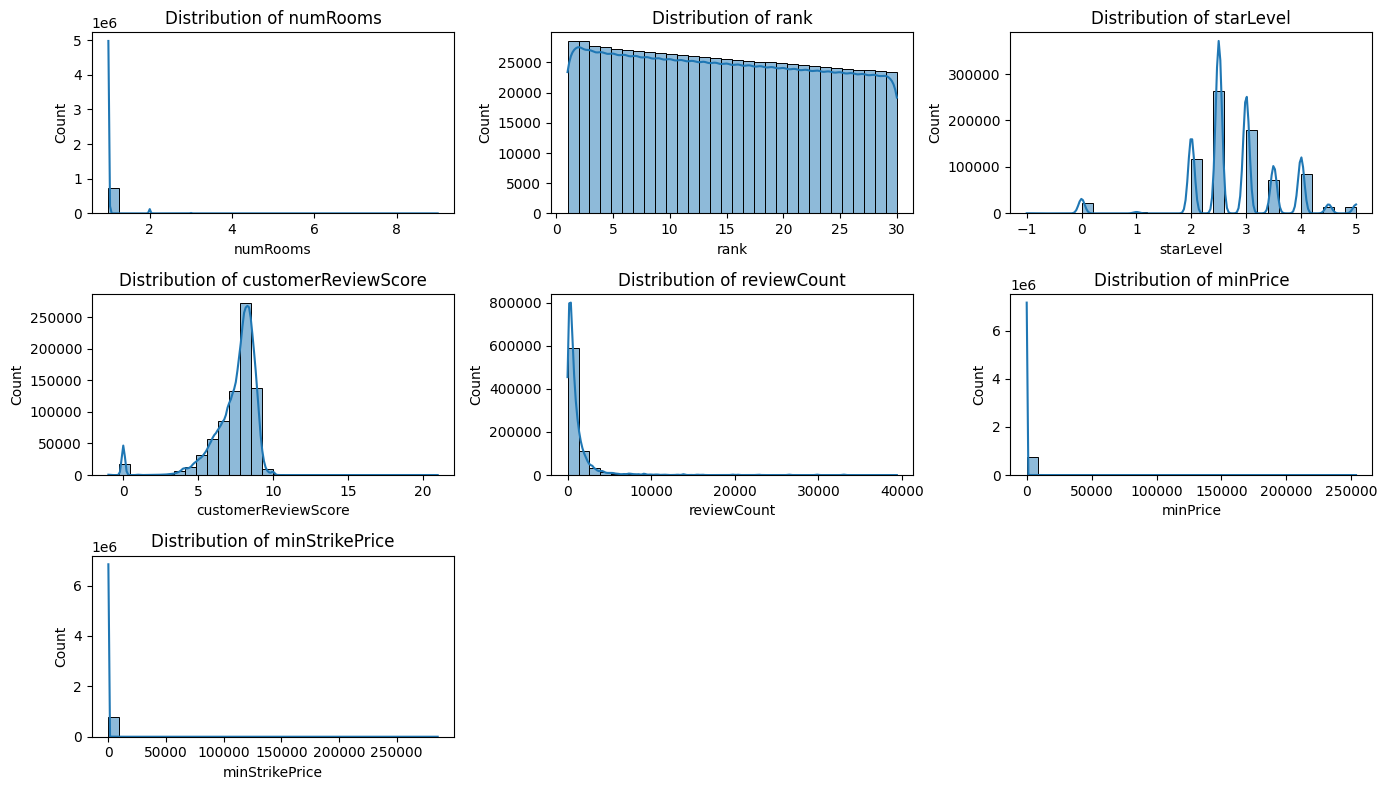

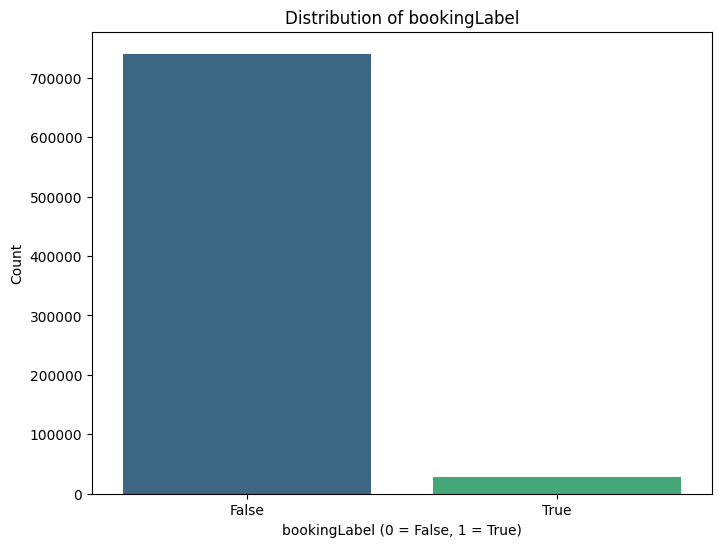

clickLabel:
clickLabel
False    0.954211
True     0.045789
Name: proportion, dtype: float64


/var/folders/fd/qk43m_591sbfv7hhlz7_dnmm0000gn/T/ipykernel_17809/828760509.py:208: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


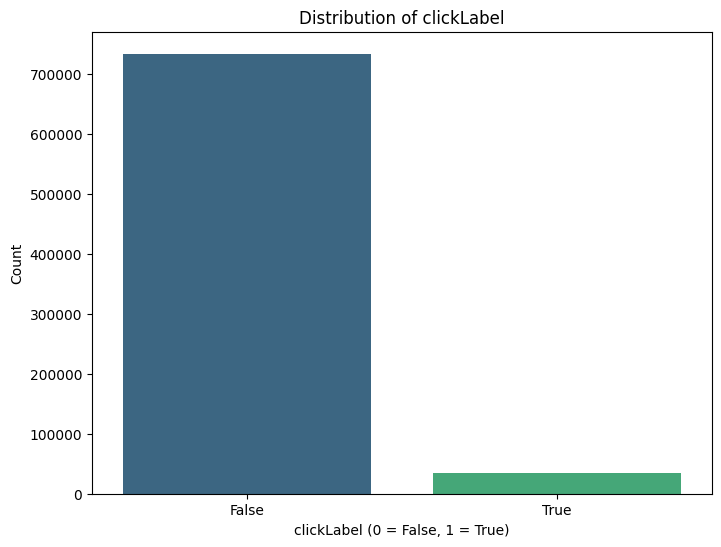

Checking Click-to-Book Relationship


Click-to-Book Relationship:
bookingLabel     False     True 
clickLabel                      
False         1.000000  0.000000
True          0.187551  0.812449
Rank Effect Analysis

Booking Rate by Rank Bucket:
bookingLabel     False     True 
rank_bucket                     
(0.999, 6.0]  0.869670  0.130330
(6.0, 12.0]   0.977414  0.022586
(12.0, 18.0]  0.989078  0.010922
(18.0, 24.0]  0.993449  0.006551
(24.0, 30.0]  0.995524  0.004476


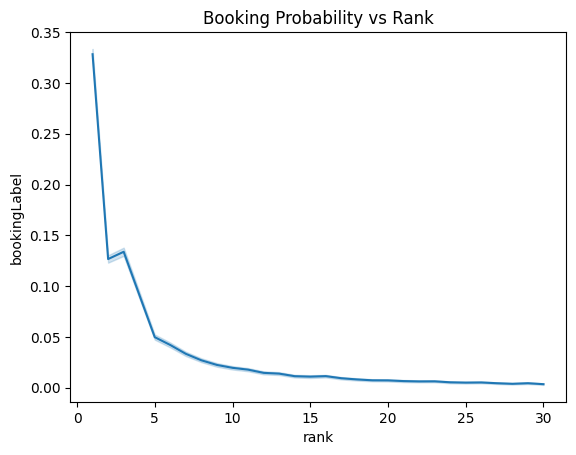

Plotting Correlation Matrix



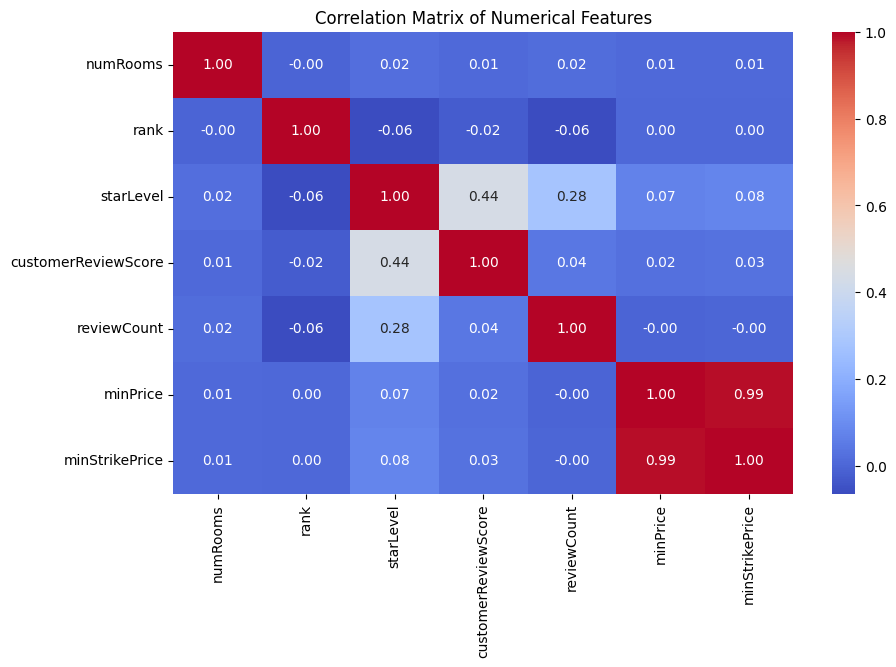

In [16]:
numerical_cols = [
    "numRooms",
    "rank",
    "starLevel",
    "customerReviewScore",
    "reviewCount",
    "minPrice",
    "minStrikePrice"
]

date_cols = [
    "checkInDate",
    "checkOutDate",
    "searchDate"
]

categorical_cols = [
    "destinationName",
    "vipTier",
    "deviceCode",
    "signedInFlag",
    "freeBreakfastFlag",
    "freeInternetFlag"
]

id_cols = [
    "searchId",
    "userId",
    "hotelId",
    "brandId"
]

target_cols = [
    "bookingLabel",
    "clickLabel"
]

detailed_numerical_cols = [
    "starLevel",
    "customerReviewScore",
    "reviewCount"
]

run_data_exploration(df,
                     numerical_cols, 
                     date_cols, 
                     categorical_cols, 
                     id_cols, 
                     detailed_numerical_cols, 
                     target_cols)
